In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import multiprocessing

# Disable CUDA because only one gpu device allows only a single chain
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    multiprocessing.cpu_count()
)
import jax

jax.default_backend()
jax.devices()

2023-07-18 21:52:23.720579: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]

In [3]:
from yomi_skill.model import YomiModel, weight_by
from yomi_skill.models import *
from yomi_skill.models.mu_glicko import *
from yomi_skill.yomi import historical_record
import pandas
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import tempfile

from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split, cross_validate

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
fit_dir = tempfile.mkdtemp()

In [5]:
tournament_games = historical_record.latest_tournament_games()
sirlin_games = historical_record.sirlin_db()
games = pandas.concat([tournament_games, sirlin_games]).reset_index(drop=True)

games

,match_date,player_1,character_1,win,character_2,player_2,public
0,2014-07-06 00:00:00,Jengajam,menelker,0,setsuki,fodazd,True
1,2014-07-06 00:00:00,MadKing,quince,1,setsuki,CKR,True
2,2014-07-06 00:00:00,Raziek,zane,1,quince,MadKing,True
3,2014-07-06 00:00:00,Raziek,zane,1,quince,MadKing,True
4,2014-07-06 00:00:00,Raziek,zane,1,quince,MadKing,True
...,...,...,...,...,...,...,...
120301,2015-09-07 19:11:01,DarkSephiroth,menelker,0,valerie,BONZAI,False
120302,2015-09-07 19:09:31,Kirandio,degrey,0,menelker,pfiidude,False
120303,2015-09-07 19:17:11,hartley,valerie,0,rook,EricF,False
120304,2015-09-07 19:17:43,DarkSephiroth,menelker,0,valerie,BONZAI,False


In [6]:
games = historical_record.augment_dataset(games)

Constructing PC category


In [7]:
min_games = 0
warmup = 500
samples = 1000

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    games, games.win.astype('int'), random_state=42
)

In [9]:
MODELS = {
    model.model_name: model
    for model_type in YomiModel.__subclasses__()
    for model in model_type.__subclasses__()
}

In [10]:
MODELS

{'mu_pc_glicko': yomi_skill.models.mu_pc_glicko.MUPCGlicko,
 'pc_elo': yomi_skill.models.pc_elo.PCElo,
 'mu_pc_elo_c': yomi_skill.models.mu_pc_elo_c.MUPCEloC,
 'char_skill_skelo_skill_deficit': yomi_skill.models.char_skill_skelo_skill_deficit.CharSkillSkeloSkillDeficit,
 'mu': yomi_skill.models.mu_only.MUOnly,
 'glicko': yomi_skill.models.glicko.Glicko,
 'elo': yomi_skill.models.elo.Elo,
 'mu_pc_elo_vol': yomi_skill.models.mu_pc_elo_vol.MUPCEloVol,
 'char_skill_glicko_skill_deficit': yomi_skill.models.char_skill_glicko_skill_deficit.CharSkillGlickoSkillDeficit,
 'mu_pc_elo': yomi_skill.models.mu_pc_elo.MUPCElo,
 'full': yomi_skill.models.full.Full,
 'mu_elo': yomi_skill.models.mu_elo.MUElo,
 'mu_glicko': yomi_skill.models.mu_glicko.MUGlicko,
 'pc_glicko': yomi_skill.models.pc_glicko_only.PCGlicko}

In [11]:
model_names = [
    'full',
    # 'mu',
    # 'elo',
    'mu_elo',
    # 'pc_elo',
    'mu_pc_elo',
    # 'mu_pc_elo_vol',
    # 'mu_pc_elo_c',
    # 'glicko',
    # 'mu_glicko',
    # 'pc_glicko',
    # 'mu_pc_glicko',
]
models = {model_name: MODELS[model_name](min_games=min_games, warmup=warmup, samples=samples) for model_name in model_names}

In [40]:
pipelines = {}
pipelines['full'] = models['full'].pipeline(
        transform__elo__initial_time=games.match_date.min(),
        transform__pc_elo__initial_time=games.match_date.min(),
        model__min_games=min_games,
        model__warmup=warmup,
        model__samples=samples,
    )
pipelines['mu_elo'] = models['mu_elo'].pipeline(
        transform__elo__initial_time=games.match_date.min(),
        model__min_games=min_games,
        model__warmup=warmup,
        model__samples=samples,
    )
pipelines['mu_pc_elo'] = models['mu_pc_elo'].pipeline(
        transform__pc_elo__initial_time=games.match_date.min(),
        model__min_games=min_games,
        model__warmup=warmup,
        model__samples=samples,
    )

In [41]:
from sklearn import set_config
set_config(transform_output="pandas")

In [92]:
pipelines['full'].fit(X_train[:20], y_train[:20])

KeyError: "Dimensions {'games'} are unknown to the model and cannot be used to specify a `shape`."

In [77]:
for model_name in model_names:
    pipelines[model_name].fit(
        X_train,
        y_train,
        # sample_weight=X_train[f'{models[model_name].weight_key}_weight']
    )

KeyboardInterrupt: 

In [56]:
pred_test = {
    model_name: pipelines[model_name].predict_proba(X_test)[:, 1]
    for model_name in pipelines
    if hasattr(pipelines[model_name]['model'], 'inf_data_')
}

In [57]:
df_pred_test = pandas.DataFrame(pred_test)

KeyError: 'mu_pc_elo'

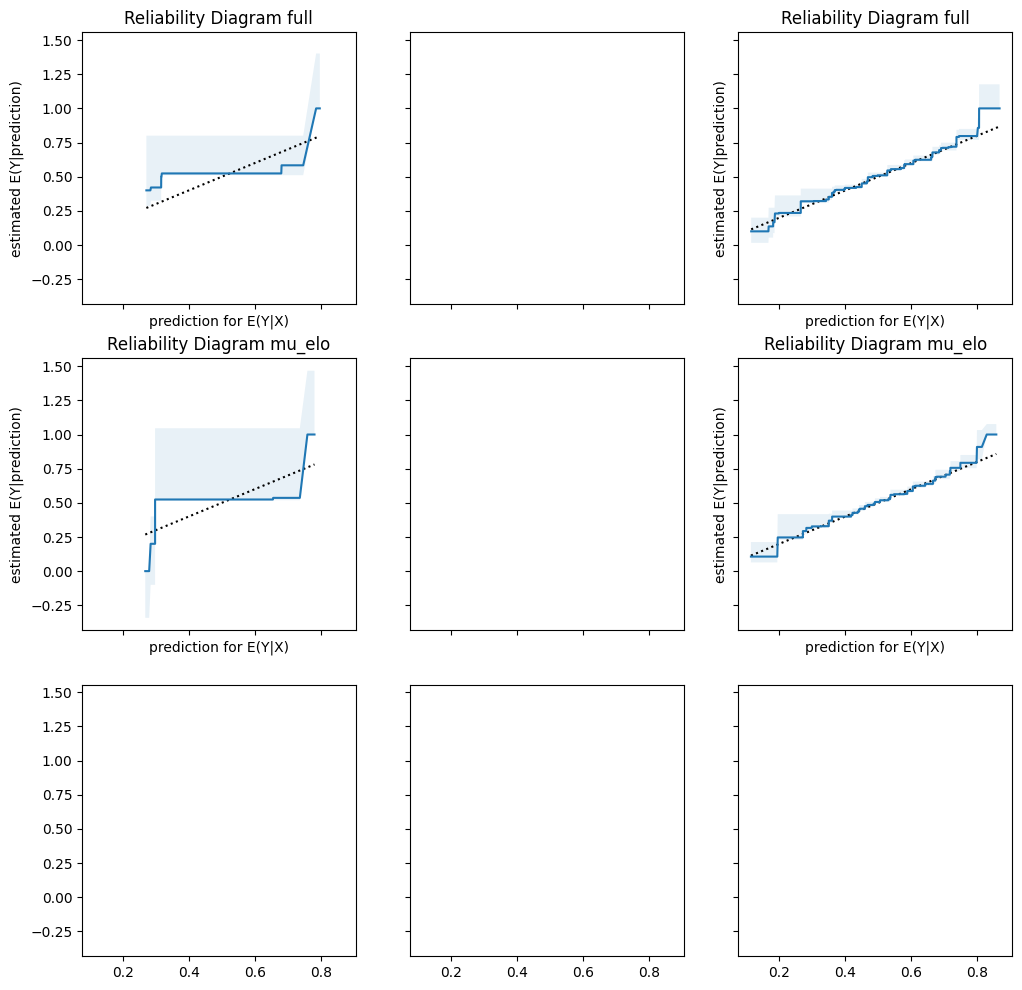

In [63]:
import matplotlib.pyplot as plt
from model_diagnostics.calibration import compute_bias, plot_bias, plot_reliability_diagram
fig, axes = plt.subplots(ncols=3, nrows=len(model_names), figsize=(12, 4*len(model_names)), sharex=True, sharey=True)
mirror_matches = (X_test.character_1 == X_test.character_2).to_numpy()

for i, model_name in enumerate(model_names):
    plot_reliability_diagram(
        y_obs=y_test[mirror_matches],
        y_pred=df_pred_test[model_name][mirror_matches],
        # weights=X_test[models[model_name].weight_key + '_weight'],
        n_bootstrap=100,
        ax=axes[i][0],
    )
    plot_reliability_diagram(
        y_obs=y_test,
        y_pred=df_pred_test[model_name],
        # weights=X_test[models[model_name].weight_key + '_weight'],
        n_bootstrap=100,
        ax=axes[i][2],
    )

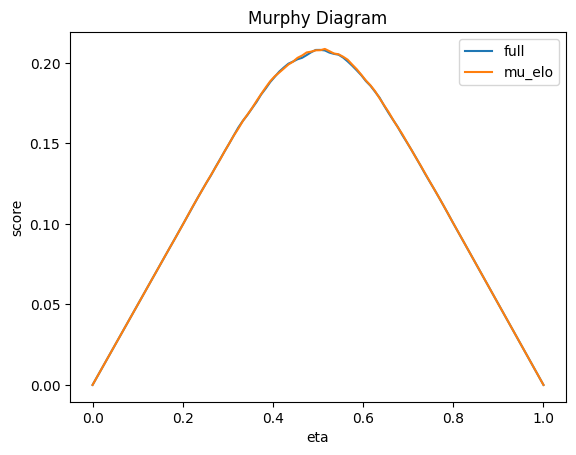

In [64]:
from model_diagnostics.scoring import SquaredError, plot_murphy_diagram

ax = plot_murphy_diagram(
    y_obs=y_test,
    y_pred=df_pred_test,
)

In [65]:
from model_diagnostics.scoring import SquaredError, decompose
import polars as pl

df_list = []
for model_name in df_pred_test:
    df = decompose(
        scoring_function=SquaredError(),
        y_obs=y_test,
        y_pred=df_pred_test[model_name],
        # weights=X_test[models[model_name].weight_key + '_weight'],
    )
    df = df.with_columns(pl.lit(model_name).alias("model"))
    df_list.append(df)
pl.concat(df_list)[:, [-1, 0, 1, 2, 3]]


model,miscalibration,discrimination,uncertainty,score
str,f64,f64,f64,f64
"""full""",0.000602,0.011719,0.249995,0.238877
"""mu_elo""",0.000494,0.011329,0.249995,0.23916


In [86]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import loguniform, uniform
from sklearn.model_selection import GridSearchCV
search = HalvingRandomSearchCV(
    pipelines['full'],
    {
        'transform__elo__default_k': loguniform(1, 200),
        'transform__elo__initial_value': uniform(1000, 2000),
        'transform__pc_elo__default_k': loguniform(1, 200),
        'transform__pc_elo__initial_value': uniform(1000, 2000),
    },
    scoring='neg_brier_score',
    verbose=2,
    n_candidates=100
)
search.fit(games, games.win)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 8
min_resources_: 20
max_resources_: 120306
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 100
n_resources: 20
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Compiling...
Compilation time =  0:00:02.159146
Sampling...
Sampling time =  0:00:13.202217
Transforming variables...
Transformation time =  0:00:01.426560
[CV] END transform__elo__default_k=2.0000244812278627, transform__elo__initial_value=2460.6586682079524, transform__pc_elo__default_k=7.7570960478709425, transform__pc_elo__initial_value=1673.9026352301967; total time=  17.1s
[CV] END transform__elo__default_k=2.0000244812278627, transform__elo__initial_value=2460.6586682079524, transform__pc_elo__default_k=7.7570960478709425, transform__pc_elo__initial_value=1673.9026352301967; total time=   0.0s
[CV] END transform__elo__default_k=2.0000244812278627, transform__elo__initial_value=2460.6586682079524, transform__pc_elo__defa

KeyboardInterrupt: 

In [66]:
import arviz
for model in df_pred_test:
    print(model)
    display(arviz.summary(pipelines['model'].inf_data_))

full


KeyError: 'model'

In [ ]:
import arviz
arviz.plot_pair(models['full'].inf_data_, var_names=['pc_elo_sum_intercept', 'elo_sum_intercept']

In [ ]:
scores = cross_validate(
    elo_only,
    hist_games,
    y=hist_games.win,
    fit_params={'sample_weights': hist_games.weight},
    cv=5,
    scoring=(
        "neg_brier_score",
        "neg_log_loss",
        "roc_auc",
        "precision",
        "recall",
        "f1",
    ),
)
pandas.DataFrame(scores).describe()

In [ ]:
scores = cross_validate(
    elo_only,
    hist_games,
    y=hist_games.win,
    cv=5,
    scoring=(
        "neg_brier_score",
        "neg_log_loss",
        "roc_auc",
        "precision",
        "recall",
        "f1",
    ),
)
pandas.DataFrame(scores).describe()

In [ ]:
scores = cross_validate(
    full,
    hist_games,
    y=hist_games.win,
    fit_params={'sample_weights': hist_games.weight},
    cv=5,
    scoring=(
        "neg_brier_score",
        "neg_log_loss",
        "roc_auc",
        "precision",
        "recall",
        "f1",
    ),
)
pandas.DataFrame(scores).describe()

In [ ]:
scores = cross_validate(
    full,
    hist_games,
    y=hist_games.win,
    fit_params={'sample_weights': hist_games.weight},
    cv=5,
    scoring=(
        "neg_brier_score",
        "neg_log_loss", 
        "roc_auc",
        "precision",
        "recall",
        "f1",
    ),
)
pandas.DataFrame(scores).describe()